# Export Data for Web Application 

In [4]:
from cflp_function import cflp, flp_scip, store_data_to_pickle, load_data_from_pickle, get_arc
from pulp import *
import pandas as pd
import numpy as np
# import pydeck as pdk
import geopandas as gpd
import os
# import rasterio
# from rasterio.plot import reshape_as_image
# from shapely.geometry import mapping

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# version_number = 6

### Load files and create parameters
* q_j max capacity of each j 
* f_j fixed cost of establishing each j
* set F set of farm locations
* set P set of potential digester locations
* C_ij transportation matrix 
* p_i 
* alpha
* mu

In [5]:
# Import farm_cluster_mock_5 dataset - which is the mock data for potential digester locations
potential_digester_location = pd.read_csv(r'./farm/farm_cluster_mock_5.csv')
potential_digester_location.head()

,x,y,count
0,6.870686,52.215190,25
1,6.554937,52.254895,25
2,6.730518,52.252885,42
3,6.914234,52.387401,18
4,6.664105,52.392622,32


In [6]:
farm = pd.read_csv(r"./farm/farm_mock.csv")
farm.head()

,Unnamed: 0,x,y,IND_OBJ_NA,manure_t,biogas_potential_m3
0,0,6.765843,52.314139,507920,2454,957060.0
1,1,6.837249,52.425084,507950,9827,3832530.0
2,2,6.859361,52.386225,507953,8660,3377400.0
3,3,6.753483,52.434382,507962,2913,1136070.0
4,4,6.484077,52.243620,507964,6488,2530320.0


In [7]:
folder_path = 'app_data'

In [8]:
I = load_data_from_pickle(folder_path, 'Farm_test.pickle')
        # set P     set of potential digester locations
    # Dictionary 
        # p_i       manure production of each i
d = load_data_from_pickle(folder_path, 'manure_production_test.pickle')
        # q_j       max capacity of each j 
    # Float
        # alpha     total manure production
total_manure = load_data_from_pickle(folder_path, 'total_manure_test.pickle')
    # Float defined here
        # mu        manure utilization target 

In [7]:
J = load_data_from_pickle(folder_path, 'Plant_test.pickle')
M = load_data_from_pickle(folder_path, 'max_capacity_test.pickle')
f = load_data_from_pickle(folder_path, 'fixed_cost_test.pickle')        
transport_cost = load_data_from_pickle(folder_path, 'transportation_cost_test.pickle')

In [29]:
# Converting the structure of OD matrix to fit the requirement of the SCIP FLP
transformed_dict = {}

for j, inner_dict in transport_cost.items():
    for i, value in inner_dict.items():
        transformed_dict[(i, j)] = value

# Sort the keys based on the first element (i)
sorted_keys = sorted(transformed_dict.keys())

# Create a new dictionary with sorted keys
c = {key: transformed_dict[key] for key in sorted_keys}

In [33]:
store_data_to_pickle(c, folder_path, 'c.pickle')

In [19]:
# Test complete
J = load_data_from_pickle(folder_path, 'Plant.pickle')
M = load_data_from_pickle(folder_path, 'max_capacity.pickle')
        # f_j       fixed cost of establishing each j
f = load_data_from_pickle(folder_path, 'fixed_cost.pickle')        
        # C_ij      transportation matrix 
transport_cost = load_data_from_pickle(folder_path, 'transportation_cost.pickle')

In [34]:
# def filter_Plant(plant_to_keep, original_dict):
#     # Extract key-value pairs where the key is not in the list
#     filtered_dict = {key: value for key, value in original_dict.items() if key in plant_to_keep}
#     return filtered_dict

In [18]:
Plant_all = ['All'] + [str(x) for x in plant]

In [22]:
Plant_all = ['All'] + J

In [23]:
Plant_all

['All', 0, 1, 2, 3, 4]

In [10]:

# Mock data for farm_df_copy
farm_df_copy_data = {'FarmName': ['Farm1', 'Farm2', 'Farm3'],
                     'SomeOtherColumn': [10, 20, 30]}
farm_df_copy = pd.DataFrame(farm_df_copy_data)
# farm_df_copy.set_index('FarmName', inplace=True)
farm_df_copy


,FarmName,SomeOtherColumn
0,Farm1,10
1,Farm2,20
2,Farm3,30


In [13]:
# Mock data for digester_df
digester_df_data = {'color': ['Red', 'Green', 'Blue']}
digester_df = pd.DataFrame(digester_df_data)
# digester_df.index.name = 'Digester'
digester_df

,color
0,Red
1,Green
2,Blue


In [14]:
# Mock data for assignment_decision
assignment_decision = {0: [0, 1], 1: [2]}


In [16]:
# Your corrected code
farm_df_copy['color'] = farm_df_copy.index.map({index: digester_df['color'].iloc[key] for key, indices in assignment_decision.items() for index in indices})
print(farm_df_copy)

  FarmName  SomeOtherColumn  color
0    Farm1               10    Red
1    Farm2               20    Red
2    Farm3               30  Green


## CFLP Model
* cflp: the cflp model
* find_farm_not_in_solution_plant_in_solution: disaggregating outputs for result visualization 
* plot_result: plot optimal solution (calls the previous function)

In [23]:
# Define manure use goal (mu)
target = 0.2

In [24]:
m = flp_scip(I, J, d, M, f, c, target)
m.optimize()
# Check the optimization status
if m.getStatus() == "optimal":
    print("Optimal solution found!")
    # Access the optimal solution values using m.getVal(var) for each variable var
    # Example: value_of_x = m.getVal(x_variable)
elif m.getStatus() == "infeasible":
    print("The problem is infeasible.")
elif m.getStatus() == "timelimit":
    print("Optimization stopped due to reaching the time limit.")

Optimal solution found!


In [25]:
EPS = 1.e-6
x,y,z = m.data
edges = [(i,j) for (i,j) in x if m.getVal(x[i,j]) > EPS]
facilities = [j for j in y if m.getVal(y[j]) > EPS]
print("Optimal value=", m.getObjVal())
print("Facilities at nodes:", facilities)
print("Edges:", edges)

Optimal value= 3912544.8986652894
Facilities at nodes: [1, 2, 3, 4, 5, 6, 9, 10, 12, 14, 15, 16, 17, 18, 20, 21, 22, 23]
Edges: [(70, 1), (121, 1), (13, 2), (74, 2), (117, 2), (73, 3), (13, 4), (73, 4), (70, 5), (65, 6), (71, 9), (72, 9), (39, 10), (52, 10), (71, 10), (15, 12), (26, 12), (30, 12), (71, 12), (42, 14), (48, 14), (70, 14), (127, 14), (39, 15), (41, 15), (42, 15), (65, 15), (6, 16), (18, 17), (84, 17), (4, 18), (6, 18), (95, 18), (97, 18), (97, 20), (98, 20), (15, 21), (81, 21), (84, 21), (15, 22), (92, 22), (53, 23), (97, 23)]


In [16]:
total_cost, total_fixed_cost, total_transport_cost, assignment_decision, use_plant_index = cflp(J, I, f, transport_cost, d, M, target, total_manure)

Solution Status =  Optimal


In [18]:
# # Check if the opened plants are under-utilized
# total_sum_list = [sum(farm.loc[i, 'manure_t'] for i in value) for value in assignment_decision.values()]

# potential_digester_location['allocated_manure'] = total_sum_list

# # Find the percentage of plant's capacity that is utilized
# potential_digester_location['underutilized'] = 0
# mask = potential_digester_location['allocated_manure'] > 0
# potential_digester_location.loc[mask, 'underutilized'] = (1 - (potential_digester_location.loc[mask, 'allocated_manure'] / potential_digester_location.loc[mask, 'capacity'])) * 100
# potential_digester_location

In [17]:
filename = f"./outputs/cflp_v{6}_{int(target*100)}%manure.png"  # You can choose the file extension (e.g., .png, .jpg, .pdf)

There are no duplicates in the list.


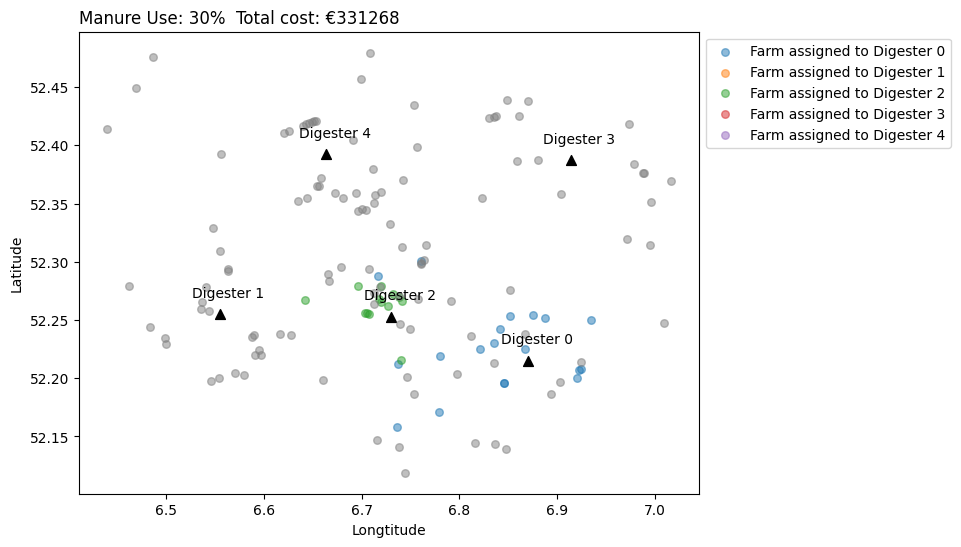

In [18]:
plot_result(J, potential_digester_location, assignment_decision, farm, I, use_plant_index, target, total_cost, filename, save_fig=False)

In [16]:
for key, value in assignment_decision.items():
    print(f"{key}: {value}")

0: []
1: []
2: [24, 40, 41, 48, 76, 77, 92, 123, 124, 125, 133, 137]
3: []
4: [66, 69, 70, 111, 113, 114, 121, 128]
